In [13]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
# import h5py
import numpy as np

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from skimage.filters import threshold_li

In [16]:
Bonev2017_mESC_path = "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES_all.mm10.mapq_30.2048.cool"

In [17]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import cooler
from cooltools.lib.numutils import observed_over_expected, adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons, set_diag, interp_nan
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from bioframe.io.fileops import read_bigwig

In [ ]:
# with removed data extrapolation

def get_target(cooler_path, padding, mseq_str, diagonal_offset=2):
    
    genome_hic_cool = cooler.Cooler(cooler_path)
    
    seq_hic_raw = genome_hic_cool.matrix(balance=True).fetch(mseq_str)

    seq_hic_nan = np.isnan(seq_hic_raw)
    # num_filtered_bins = np.sum(np.sum(seq_hic_nan,axis=0) == len(seq_hic_nan))

    # clip first diagonals and high values
    clipval = np.nanmedian(np.diag(seq_hic_raw, diagonal_offset))
    for i in range(-diagonal_offset+1, diagonal_offset):
        set_diag(seq_hic_raw, clipval, i)
    seq_hic_raw = np.clip(seq_hic_raw, 0, clipval)
    seq_hic_raw[seq_hic_nan] = np.nan
    
    # adaptively coarsegrain based on raw counts
    seq_hic_smoothed = adaptive_coarsegrain(
                        seq_hic_raw,
                        genome_hic_cool.matrix(balance=False).fetch(mseq_str),
                        cutoff=2, max_levels=8)
    seq_hic_nan = np.isnan(seq_hic_smoothed)
    
    # local obs/exp
    seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]
    log_hic_obsexp = np.log(seq_hic_obsexp)

    # crop
    if padding > 0:
        log_hic_obsexp = log_hic_obsexp[padding:-padding,:]
        log_hic_obsexp = log_hic_obsexp[:,padding:-padding]

    # # aplying Gaussian Kernel
    # kernel = Gaussian2DKernel(x_stddev=1)
    # kernel_log_hic_obsexp = convolve(log_hic_obsexp, kernel)
    
    # return kernel_log_hic_obsexp
    return log_hic_obsexp

In [18]:
def get_raw_count(cooler_path, padding, mseq_str, diagonal_offset=2):
    
    genome_hic_cool = cooler.Cooler(cooler_path)
    
    seq_hic_raw = genome_hic_cool.matrix(balance=False).fetch(mseq_str)
    
    return np.sum(seq_hic_raw)

In [19]:
seq_len_nt = 1310720
padding = (640-512) // 2

In [20]:
explained_path = "./all_explained_boundaries.tsv"
unexplained_path = "./all_unexplained_boundaries.tsv"

In [21]:
explained_tads = pd.read_csv(explained_path, sep="\t", index_col=None)
unexplained_tads = pd.read_csv(unexplained_path, sep="\t", index_col=None)

In [22]:
raw_count_sum = []

for index, row in explained_tads.iterrows():
    if index % 100 == 0:
        print("working on", index)
    mseq_str = '%s:%d-%d' % (row.chrom, row.window_start, row.window_end)
    raw_count = get_raw_count(Bonev2017_mESC_path, padding, mseq_str)
    
    raw_count_sum.append(raw_count)

working on 0
working on 100
working on 200
working on 300
working on 400
working on 500
working on 600
working on 700
working on 800
working on 900
working on 1000
working on 1100
working on 1200
working on 1300
working on 1400
working on 1500
working on 1600
working on 1700
working on 1800
working on 1900
working on 2000
working on 2100
working on 2200


In [23]:
explained_tads["raw_count"] = raw_count_sum

In [24]:
explained_tads

,SCD_h1_m0_t0,SCD_h1_m0_t1,SCD_h1_m0_t2,SCD_h1_m0_t3,SCD_h1_m0_t4,SCD_h1_m0_t5,chrom,end,rel_disruption_end,rel_disruption_start,start,type,window_end,window_start,miss_per,ins16_min,cont_sum,raw_count
0,28.90,31.60,30.78,31.38,29.98,26.33,chr1,6440000,638976,636928,6430000,down6,7091504,5780784,14.986568,-0.236667,103489.279849,1548229
1,19.08,23.00,23.40,22.11,22.56,18.77,chr1,6990000,679936,677888,6980000,up10,7641504,6330784,19.595393,-0.155549,101235.875898,1447695
2,31.97,40.22,38.90,39.62,38.53,32.78,chr1,7240000,638976,636928,7230000,down6,7891504,6580784,20.293044,-0.211251,88256.382168,1351407
3,21.60,23.02,14.69,14.59,16.72,13.99,chr1,10230000,626688,624640,10220000,down12,10881504,9570784,9.509099,-0.293484,118880.626475,1842257
4,39.70,47.66,73.60,72.10,63.03,55.10,chr1,12850000,647168,645120,12840000,down2,13501504,12190784,5.383613,-0.440818,105281.350459,2144923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,22.80,23.92,32.97,33.72,29.19,26.48,chr9,118040000,673792,671744,118030000,up7,118691504,117380784,10.986476,-0.462594,93502.200621,1882219
2207,38.22,39.88,54.62,54.72,48.94,43.53,chr9,118510000,641024,638976,118500000,down5,119161504,117850784,8.765850,-0.429196,109745.320601,2195107
2208,18.34,19.20,23.94,23.47,22.03,19.48,chr9,118910000,659456,657408,118900000,tad5,119561504,118250784,0.389484,-0.446849,113586.266845,2554525
2209,27.23,28.90,44.34,43.94,38.90,33.94,chr9,120130000,671744,669696,120120000,up6,120781504,119470784,5.762457,-0.245315,101097.964629,2436104


In [25]:
explained_tads.to_csv("all_explained_boundaries.tsv", sep="\t", index=False)

In [27]:
raw_count_sum = []

for index, row in unexplained_tads.iterrows():
    if index % 100 == 0:
        print("working on", index)
    mseq_str = '%s:%d-%d' % (row.chrom, row.window_start, row.window_end)
    raw_count = get_raw_count(Bonev2017_mESC_path, padding, mseq_str)
    
    raw_count_sum.append(raw_count)

working on 0
working on 100
working on 200
working on 300
working on 400
working on 500
working on 600
working on 700
working on 800
working on 900
working on 1000
working on 1100
working on 1200
working on 1300
working on 1400
working on 1500
working on 1600
working on 1700
working on 1800
working on 1900
working on 2000
working on 2100
working on 2200


In [28]:
unexplained_tads["raw_count"] = raw_count_sum

In [29]:
unexplained_tads

,SCD_h1_m0_t0,SCD_h1_m0_t1,SCD_h1_m0_t2,SCD_h1_m0_t3,SCD_h1_m0_t4,SCD_h1_m0_t5,chrom,end,rel_disruption_end,rel_disruption_start,start,type,window_end,window_start,miss_per,ins16_min,cont_sum,raw_count
0,12.625,13.9800,9.8400,9.760,10.5600,8.8000,chr1,4410000,667648,665600,4400000,up4,5061504,3750784,9.879583,-0.204339,112161.794404,1685338
1,0.717,0.8345,0.9307,0.885,0.8260,0.6606,chr1,4410000,620544,618496,4400000,down15,5061504,3750784,9.879583,-0.204339,112161.794404,1685338
2,1.633,1.6190,1.6640,1.480,1.4375,1.1750,chr1,5160000,622592,620544,5150000,down14,5811504,4500784,14.626723,-0.233104,104884.328765,1718155
3,1.366,1.4660,1.3620,1.321,1.3210,1.1160,chr18,73180000,620544,618496,73170000,down15,73831504,72520784,16.061542,-0.285407,85092.546823,1620815
4,12.480,14.4100,14.8400,15.160,13.9500,11.8360,chr1,6200000,651264,649216,6190000,tad1,6851504,5540784,17.484202,-0.343384,93233.858308,1484079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,1.087,0.9897,1.3480,1.361,1.1460,1.0230,chr16,21450000,618496,616448,21440000,down16,22101504,20790784,7.270233,-0.294114,116171.558504,2344742
2259,9.890,9.0900,10.0400,10.080,9.6600,8.3100,chr9,121710000,647168,645120,121700000,down2,122361504,121050784,9.879583,-0.271511,101734.443245,2271830
2260,8.640,8.5500,8.8800,8.586,8.4700,7.2800,chr9,122360000,651264,649216,122350000,tad1,123011504,121700784,10.986476,-0.177083,81661.120567,2223400
2261,1.611,1.3910,2.0600,2.105,1.7330,1.5070,chr7,122190000,618496,616448,122180000,down16,122841504,121530784,2.325502,-0.129382,122625.100740,2437895


In [30]:
unexplained_tads.to_csv("all_unexplained_boundaries.tsv", sep="\t", index=False)

In [ ]:
from skimage.filters import threshold_li, threshold_otsu

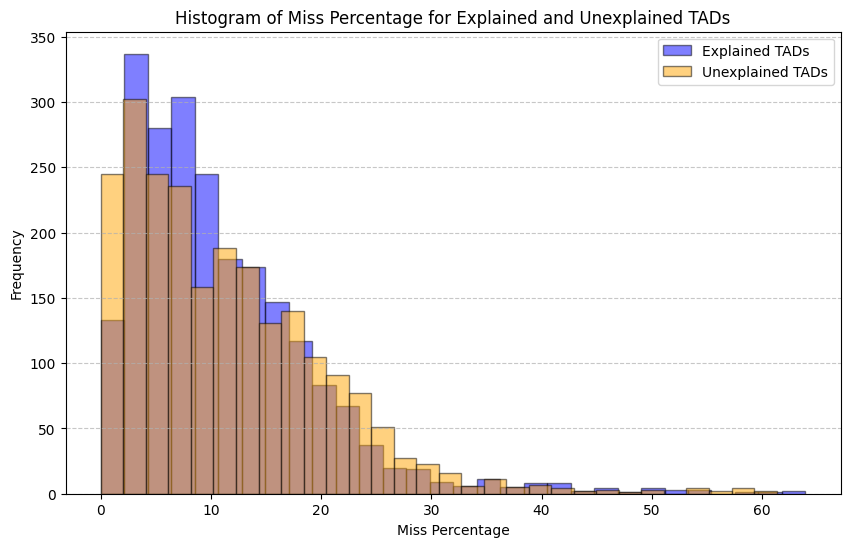

In [31]:
# Assuming explained_tads and unexplained_tads DataFrames have a column 'miss_per'
plt.figure(figsize=(10, 6))

# Plotting the histogram for explained_tads
plt.hist(explained_tads['miss_per'], bins=30, alpha=0.5, label='Explained TADs', color='blue', edgecolor='black')

# Plotting the histogram for unexplained_tads
plt.hist(unexplained_tads['miss_per'], bins=30, alpha=0.5, label='Unexplained TADs', color='orange', edgecolor='black')


# Adding labels and title
plt.xlabel('Miss Percentage')
plt.ylabel('Frequency')
plt.title('Histogram of Miss Percentage for Explained and Unexplained TADs')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.savefig("./plots/missing_data_assessment.pdf", format="pdf")
# Show the plot
plt.show()

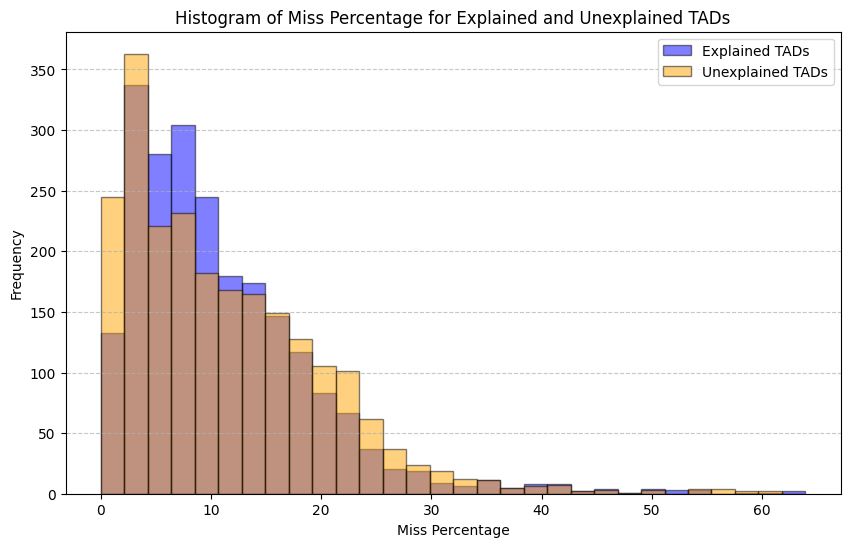

In [33]:
# Combine the data to calculate shared bins
combined_data = np.concatenate([explained_tads['miss_per'], unexplained_tads['miss_per']])
bins = np.histogram_bin_edges(combined_data, bins=30)  # Calculate shared bin edges

plt.figure(figsize=(10, 6))

# Plotting the histogram for explained_tads
plt.hist(
    explained_tads['miss_per'], bins=bins, alpha=0.5, 
    label='Explained TADs', color='blue', edgecolor='black'
)

# Plotting the histogram for unexplained_tads
plt.hist(
    unexplained_tads['miss_per'], bins=bins, alpha=0.5, 
    label='Unexplained TADs', color='orange', edgecolor='black'
)

# Adding labels and title
plt.xlabel('Miss Percentage')
plt.ylabel('Frequency')
plt.title('Histogram of Miss Percentage for Explained and Unexplained TADs')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Uncomment to save the plot
plt.savefig("./plots/missing_data_assessment.pdf", format="pdf")

# Show the plot
plt.show()


In [ ]:
thresholds_li, thresholds_otsu

In [ ]:
percentage = (len(unexplained_tads[unexplained_tads['miss_per'] > thresholds_li]) / len(unexplained_tads))*100
print(f"{round(percentage,2)}% of unexplained TADs are within windows with at least {round(thresholds_li,2)}% of missing data")

In [ ]:
len(unexplained_tads[unexplained_tads['miss_per'] > thresholds_li])

In [ ]:
len(unexplained_tads[unexplained_tads['miss_per'] > thresholds_otsu])